Neural Network for detecting ellipses

In [0]:
import json
import numpy as np
import math

import matplotlib.pyplot as plt

from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam, SGD, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import RandomUniform
from keras import backend as K
from keras import regularizers
from keras import losses


In [0]:
filepath_train = '/content/drive/My Drive/Colab_data/full_dataset_train.json'
with open(filepath_train) as json_file:
    training_data = json.load(json_file)

filepath_test = '/content/drive/My Drive/Colab_data/full_dataset_test.json'
with open(filepath_test) as json_file:
    test_data = json.load(json_file)

In [3]:
print(len(training_data))
print(len(test_data))

4891
413


In [0]:
def split_and_shuffle_data(data):
    # min_height = 1.2

    len_data = len(data)
    lst = []

    for img_idx in range(len_data):
        data_point = data[str(img_idx)]
        A = data_point['ellipse'][0]
        B = data_point['ellipse'][1]
        C = data_point['ellipse'][2]
        D = data_point['ellipse'][3]
        E = data_point['ellipse'][4]
        F = data_point['ellipse'][5]

        inner_square = math.sqrt( (A-C)**2 + B**2)
        outside = 1.0 / (B**2 - 4*A*C)
        a = outside * math.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2 - 4*A*C)*F) * ( (A+C) + inner_square))
        b = outside * math.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2 - 4*A*C)*F) * ( (A+C) - inner_square))

        ellipse = np.array([a,b])

        # ellipse = np.array(data_point['ellipse'])
        gt = np.array(data_point['ground_truth'])
        # if gt[2] > min_height:
        lst.append([ellipse, gt])

    array = np.array(lst)
    np.random.shuffle(array)
    x, y = np.transpose(array, axes=(1,0))
    return np.asarray(x.tolist()), np.asarray(y.tolist())

In [55]:
x_train, y_train = split_and_shuffle_data(training_data)
x_test, y_test = split_and_shuffle_data(test_data)

print(len(x_train))
print(len(x_test))

4891
413


In [53]:
# Check data
# b**2 - 4*a*c < 0
count = 0
for parameters in x_train:
    if parameters[1]**2 - 4*parameters[0]*parameters[2] == 0:
        count += 1
print(count)


0


In [0]:
def show_and_save_training_history(history, run_id, part_id=0):
    # Plot training & validation accuracy values
    # plt.plot(history.history['acc'])
    # plt.plot(history.history['val_acc'])
    # plt.title('Model accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    # plt.savefig('model_'+str(run_id)+'accuracy.svg')
    # plt.savefig('model_'+str(run_id)+'accuracy.png')
    # plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylim(top=2.0)
    plt.ylim(bottom=0.0)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    # plt.savefig('images/model_'+str(run_id)+'_'+str(part_id)+'loss.svg')
    # plt.savefig('images/model_'+str(run_id)+'_'+str(part_id)+'loss.png')
    plt.show()

In [0]:
def show_and_save_multi_training_history(history, run_id, part_id=0):
    # Plot training & validation loss values
    plt.figure(figsize=(6, 8))
    plt.subplot(3, 1, 1)

    plt.plot(history.history['output_x_loss'])
    plt.plot(history.history['val_output_x_loss'])
    plt.title('Model loss x')
    plt.ylim(top=1.0)
    plt.ylim(bottom=0.0)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    plt.subplot(3, 1, 2)
    plt.plot(history.history['output_y_loss'])
    plt.plot(history.history['val_output_y_loss'])
    plt.title('Model loss y')
    plt.ylim(top=1.0)
    plt.ylim(bottom=0.0)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    plt.subplot(3, 1, 3)
    plt.plot(history.history['output_z_loss'])
    plt.plot(history.history['val_output_z_loss'])
    plt.title('Model loss z')
    plt.ylim(top=1.0)
    plt.ylim(bottom=0.0)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    plt.savefig('images/model_'+str(run_id)+'_'+str(part_id)+'multi_loss.svg')
    plt.savefig('images/model_'+str(run_id)+'_'+str(part_id)+'multi_loss.png')
    plt.tight_layout()
    plt.show()

In [0]:
def make_report(run_id, min_val_loss, min_val_loss_id, init_weight_limit,
                hidden_units, activation_fn, dropout_rate, batch_size,
                max_epochs, learning_rate, l2_reg, use_optimizer, use_loss,
                normalize_input, normalize_output, part_id=0):
    filename = 'history/training_history_'+str(run_id)+'.txt'
    
    print("Best loss:", min_val_loss)
    print("Best loss id:", min_val_loss_id)

    try:
        with open(filename, 'r') as f:
            lines = f.read().splitlines()
            last_line = lines[-1]
            prev_best_val_loss = float(last_line)
            print("Previous best loss:", prev_best_val_loss)
        
        # Only write to file if better than previous
        if min_val_loss > prev_best_val_loss:
            print("Not better than previous run")
            return
        else:
            print("New best!")
    except:
        print("This is the first entry in the file")

    # Open a file with access mode 'a'
    file_object = open(filename, 'a')

    file_object.write('\n###############################################\n')
    file_object.write('Part: '+str(part_id)+'\n')
    file_object.write('Lowest value loss: ' + str(min_val_loss) + '\n')
    file_object.write('Epoch with lowest value loss: ' + str(min_val_loss_id) + '\n')
    file_object.write('\n')

    file_object.write('# Dataset:\n')
    file_object.write('Normalize input: '+str(normalize_input)+'\n')
    file_object.write('Normalize output: '+str(normalize_output)+'\n')
    file_object.write('\n')

    file_object.write('# Architecture:\n')
    file_object.write('Hidden layers: '+str(len(hidden_units))+'\n')
    file_object.write('Hidden units: '+str(hidden_units)+'\n')
    file_object.write('Activation function: '+str(activation_fn)+'\n')
    file_object.write('Optimizer: '+str(use_optimizer)+'\n')
    file_object.write('Loss function: '+str(use_loss)+'\n')
    file_object.write('\n')

    file_object.write('# Hyper parameters:\n')
    file_object.write('Max epochs: '+str(max_epochs)+'\n')
    file_object.write('Batch size: '+str(batch_size)+'\n')
    file_object.write('Learning rate: '+str(learning_rate)+'\n')
    file_object.write('L2 regularization: '+str(l2_reg)+'\n')
    file_object.write('Dropout rate: '+str(dropout_rate)+'\n')
    file_object.write('Initial weight limit: '+str(init_weight_limit)+'\n')
    file_object.write('###############################################\n')
    file_object.write('Best:\n')
    file_object.write(str(min_val_loss))

    # Close the file
    file_object.close()

In [0]:
def normalize_data(norm_input=False, norm_output=False):

    # Choose the first 4 input layers

    # Normalize the data
    x_mean = np.mean(x_train, axis = 0)
    x_std = np.std(x_train, axis = 0)

    y_mean = np.mean(y_train, axis = 0)
    y_std = np.std(y_train, axis = 0)

    x_train_std = (x_train - x_mean) / x_std
    y_train_std = (y_train - y_mean) / y_std

    x_test_std = (x_test - x_mean) / x_std
    y_test_std = (y_test - y_mean) / y_std

    ########################################
    # Choose between
    # standarized or not standarized
    # input and output data
    if norm_input:
        x_train_in_use_l = x_train_std
        x_test_in_use_l = x_test_std
    else:
        x_train_in_use_l = x_train
        x_test_in_use_l = x_test

    if norm_output:
        y_train_in_use_l = y_train_std
        y_test_in_use_l = y_test_std
    else:
        y_train_in_use_l = y_train
        y_test_in_use_l = y_test
    
    return x_train_in_use_l, x_test_in_use_l, y_train_in_use_l, y_test_in_use_l, y_mean, y_std

Train on 3912 samples, validate on 979 samples
Epoch 1/1000
3912/3912 [==============================] - 2s 623us/step - loss: 0.5812 - val_loss: 0.3012
Epoch 2/1000
3912/3912 [==============================] - 1s 130us/step - loss: 0.1696 - val_loss: 0.0870
Epoch 3/1000
3912/3912 [==============================] - 1s 133us/step - loss: 0.0423 - val_loss: 0.0158
Epoch 4/1000
3912/3912 [==============================] - 1s 133us/step - loss: 0.0068 - val_loss: 0.0038
Epoch 5/1000
3912/3912 [==============================] - 1s 140us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/1000
3912/3912 [==============================] - 0s 127us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/1000
3912/3912 [==============================] - 1s 152us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/1000
3912/3912 [==============================] - 1s 166us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/1000
3912/3912 [==============================] - 1s 131us/step - loss: 9.4634e-04 - val_loss: 0.

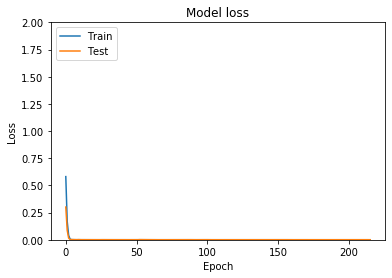

In [67]:
def train_model(prev_best_loss, run_id, part_id, init_weight_limit, hidden_units, activation_fn,
                    dropout_rate, batch_size, max_epochs, learning_rate, l2_reg,
                    use_optimizer, use_loss, normalize_input, normalize_output):
    # Set up the dataset
    (x_train_in_use, x_test_in_use,
    y_train_in_use, y_test_in_use, y_mean, y_std) = normalize_data(norm_input=normalize_input,
                                                        norm_output=normalize_output)
    
    num_inputs = 2

    # x_train_in_use = x_train_in_use[:,[0,2,3,4,5]]
    # x_test_in_use = x_test_in_use[:,[0,2,3,4,5]]

    y_train_x = y_train_in_use[:,0]
    y_train_y = y_train_in_use[:,1]
    y_train_z = y_train_in_use[:,2]

    y_test_x = y_test_in_use[:,0]
    y_test_y = y_test_in_use[:,1]
    y_test_z = y_test_in_use[:,2]
    ####################################

    random_uniform_initializer = RandomUniform(minval=-init_weight_limit, maxval=init_weight_limit, seed=None)

    # Create model
    inputs = Input(shape=(num_inputs,), name="input")

    # layer_x = Dense(units=hidden_units[0], activation=activation_fn,
    #                 kernel_initializer=random_uniform_initializer, name="hidden_x")(inputs)
    # layer_y = Dense(units=hidden_units[0], activation=activation_fn,
    #                 kernel_initializer=random_uniform_initializer, name="hidden_y")(inputs)
    layer_z = Dense(units=hidden_units[0], activation=activation_fn,
                    kernel_initializer=random_uniform_initializer,
                    kernel_regularizer=regularizers.l2(l2_reg),                    
                    name="hidden_z")(inputs)

    # Add more layers if hidden_layers > 1
    for i in range(len(hidden_units)-1):
        # layer_x = Dense(units=hidden_units[i], activation=activation_fn,
        #             kernel_initializer=random_uniform_initializer, name="hidden_x_"+str(i))(layer_x)
        # layer_y = Dense(units=hidden_units[i], activation=activation_fn,
        #                 kernel_initializer=random_uniform_initializer, name="hidden_y_"+str(i))(layer_y)
        layer_z = Dense(units=hidden_units[i+1], activation=activation_fn,
                        kernel_initializer=random_uniform_initializer,
                        kernel_regularizer=regularizers.l2(l2_reg),
                        name="hidden_z_"+str(i))(layer_z)

    # output_x = Dense(units=1, kernel_initializer=random_uniform_initializer, name="output_x")(layer_x)
    # output_y = Dense(units=1, kernel_initializer=random_uniform_initializer, name="output_y")(layer_y)
    output_z = Dense(units=1, kernel_initializer=random_uniform_initializer,
                     kernel_regularizer=regularizers.l2(l2_reg),
                     name="output_z")(layer_z)

    # model = Model(inputs=inputs, outputs=[output_x, output_y, output_z])
    model = None
    model = Model(inputs=inputs, outputs=output_z)

    # Choose optimizer
    if use_optimizer == 'adam':
        # Original : adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)

    elif use_optimizer == 'sgd':
        # Original: sgd = SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
        opt = SGD(lr=learning_rate)
    elif use_optimizer == 'adagrad':
        # Original: adagrad = Adagrad(learning_rate=0.01) Recommended to use lr=0.01
        opt = Adagrad(lr=learning_rate)
    else:
        opt = None

    # model.compile(loss={'output_x': use_loss, 'output_y': use_loss, 'output_z': 'mae'}, optimizer=opt)
    model.compile(loss=use_loss, optimizer=opt)

    # Run this to train the model
    STAMP = 'models/best_model_run_'+str(run_id)+'_'+str(part_id)
    early_stopping = EarlyStopping(monitor='val_loss', patience=30)
    bst_model_path = STAMP + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

    # history = model.fit(x_train_std, [y_train_x, y_train_y, y_train_z],
    history = model.fit(x_train_in_use, y_train_z,
                        validation_split=0.2,
                        # validation_data=({'input':x_test_in_use}, {'output_x':y_test_x, 'output_y':y_test_y, 'output_z':y_test_z}),
                        epochs=max_epochs, batch_size=batch_size, verbose=1,
                        callbacks=[early_stopping, model_checkpoint])

    val_loss_history = history.history['val_loss']
    min_val_loss = min(val_loss_history)
    min_val_loss_id = val_loss_history.index(min_val_loss) + 1 

    make_report(run_id, min_val_loss, min_val_loss_id, init_weight_limit,
        hidden_units, activation_fn, dropout_rate, batch_size,
        max_epochs, learning_rate, l2_reg, use_optimizer, use_loss,
        normalize_input, normalize_output, part_id)

    # show_and_save_multi_training_history(history, run_id, part_id)
    show_and_save_training_history(history, run_id, part_id)
    # test_model()

    # Save only the best
    if min_val_loss < prev_best_loss:
        model.save('models/nn_model_'+str(run_id)+'_'+str(part_id)+'.h5')
        return min_val_loss
    else:
        return prev_best_loss

####################################
# Hyperparameters and architecture
run_id = 6

init_weight_limit = 0.1
hidden_units = [256, 6, 32]
activation_fn = 'relu'
dropout_rate = 0.2
batch_size = 32
max_epochs = 1000
learning_rate = 0.001
l2_reg = 0.0000001
use_optimizer = 'adam' # {'adam', 'sgd'}
use_loss = 'mean_squared_error' # {'mean_squared_error' , 'mean_squared_logarithmic_error', 'mean_absolute_error'}
normalize_input = True
normalize_output = True
####################################

# test_list = []
test_list = [
    [256, 12, 32],
    [256, 24, 32],
    [256, 32, 32],
]

# for i in units_list:
#     for j in units_list:
#         test_list.append([i, j])

prev_best_loss = 1000
part_id = 0
# for part_id in range(len(test_list)):
#     hidden_units = test_list[part_id]
#     print('hidden_units: ', end="")
#     print(hidden_units)

prev_best_loss = train_model(prev_best_loss, run_id, part_id, init_weight_limit, hidden_units, activation_fn,
        dropout_rate, batch_size, max_epochs, learning_rate, l2_reg,
        use_optimizer, use_loss, normalize_input, normalize_output)

In [68]:
# Load model to memory
run_id = 6
part_id = 0
model = load_model('models/nn_model_'+str(run_id)+'_'+str(part_id)+'.h5')
model.load_weights('models/best_model_run_'+str(run_id)+'_'+str(part_id)+'.h5')

model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden_z (Dense)             (None, 256)               768       
_________________________________________________________________
hidden_z_0 (Dense)           (None, 6)                 1542      
_________________________________________________________________
hidden_z_1 (Dense)           (None, 32)                224       
_________________________________________________________________
output_z (Dense)             (None, 1)                 33        
Total params: 2,567
Trainable params: 2,567
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Get dataset
(x_train_in_use, x_test_in_use,
    y_train_in_use, y_test_in_use,
    y_mean, y_std) = normalize_data(norm_input=True, norm_output=True)

y_train_z = y_train_in_use[:,2]
y_test_z = y_test_in_use[:,2]


print("y mean:", y_mean)
print("y std:", y_std)

# x_train_in_use = x_train_in_use[:,[0,2,3,4,5]]
# x_test_in_use = x_test_in_use[:,[0,2,3,4,5]]
########################################

# Analyze weights
# first_weights = model.trainable_weights[0]
# # print(first_weights.shape)
# for input_id in range(6):
#     w = K.eval(first_weights[input_id])
#     print("Weights from input", input_id)
#     print("Mean:", np.mean(w))
#     print("Std:", np.std(w))
#     print()

# Analyze activations
# layer_outputs = [layer.output for layer in model.layers[1:]]
# Extracts the outputs of the top 12 layers
# activation_model = Model(inputs=model.input,
#     outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
# activations = activation_model.predict(x_test_in_use) 
# first_layer_activation = activations[0]
# print(first_layer_activation[0].shape)
# plt.matshow(first_layer_activation)

# results = model.evaluate(x_test_in_use, [y_test_x, y_test_y, y_test_z], batch_size=128)
results = model.evaluate(x_test_in_use, y_test_z, batch_size=32)
print('test loss:', results)

y mean: [-0.15933413  0.03610403  5.56289522]
y std: [1.37827808 2.27332637 1.74280007]
413/413 [==============================] - 0s 75us/step
test loss: 0.0006734766650969753


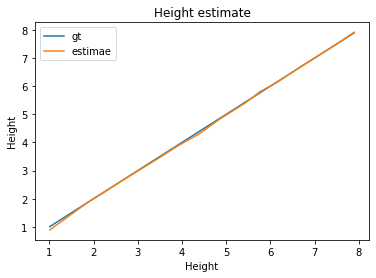

In [80]:
# Run this to test the model on test_dataset
def test_model(model):
    # run_id = 3
    # model = load_model('nn_model_'+str(run_id)+'.h5')
    # model.load_weights('best_model_run_'+str(run_id)+'.h5')

    classes = model.predict(x_test_in_use)


    # ids = [136, 74, 9, 12, 49, 1, 16, 3, 11, 5, 4, 2, 15, 7]
    ids = [103, 30, 17, 6, 23, 5, 20, 2, 3, 24, 18, 7, 1, 8]

    range_min = np.arange(1.0, 8.0, 0.5)
    range_max = np.arange(1.5, 8.5, 0.5)

    # print(range_min)
    # print(range_max)

    # gt_plot = y_test[ids][:,2]
    # est_plot = classes[2][ids][:,0]

    y_mean = [-0.15933413, 0.03610403, 5.56289522]
    y_std = [1.37827808, 2.27332637, 1.74280007]

    gt_plot = y_test_in_use[ids][:,2]*y_std[2] + y_mean[2]
    est_plot = classes[ids][:,0]*y_std[2] + y_mean[2]
    # print(gt_plot)
    # print(est_plot)

    plt.plot(gt_plot, gt_plot)
    plt.plot(gt_plot, est_plot)
    plt.title('Height estimate')
    plt.ylabel('Height')
    plt.xlabel('Height')
    plt.legend(['gt', 'estimate'], loc='upper left')
    plt.show()


def find_ids_in_even_range(model):
    classes = model.predict(x_test_in_use)

    range_min = np.arange(1.0, 8.0, 0.5)
    range_max = np.arange(1.5, 8.5, 0.5)

    output_size = 1
    new_id = []
    count = 0
    i = 0
    print(min(y_test[:,2]))
    while count < len(range_min):
    # for i in ids:
        if y_test[i][2] > range_min[count] and y_test[i][2] < range_max[count]:
            # print("ID:", i)
            # print("Ground truth:", end=" [")
            # for j in range(output_size):
            #     print(str(round(y_test_in_use[i][j], 4)).rjust(8), end="")
            # print(']')
            # print("Prediction:", end="   [")
            # for j in range(output_size):
            #     print(str(round(classes[j][i][0]*y_std[j] + y_mean[j], 4)).rjust(8), end="")
            #     print(str(round(classes[j][i][0], 4)).rjust(8), end="")
            #     print(str(round(classes[i][0], 4)).rjust(8), end="")
            # print(']\n')
            count += 1
            new_id.append(i)
            i = 0
        i += 1

    print(new_id)


# find_ids_in_even_range(model)
test_model(model)

In [0]:
####################
# 4.
# 0.0912 - Veldig bra
# batch_size=2
# model.add(Dense(units=128, activation='relu', input_shape=(6,),
#                   kernel_initializer=random_uniform_initializer,
#                   activity_regularizer=regularizers.l1(0.001)))
# Dropout 0.1


####################
# 5. 0.2369 stabilt

####################
# 6. 0.0871 bra!
# random_uniform_initializer = RandomUniform(minval=-0.05, maxval=0.05, seed=None)

# model.add(Dense(units=128, activation='relu', input_shape=(6,),
#                 kernel_initializer=random_uniform_initializer,
#                 # kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.0001)))
# model.add(Dropout(0.1))
# batch_size=1
# adam = Adam(lr=0.0001, beta_1=0.8, beta_2=0.9)

####################
# 7. 0.0742 Nice!
# random_uniform_initializer = RandomUniform(minval=-0.05, maxval=0.05, seed=None)

# model.add(Dense(units=128, activation='relu', input_shape=(6,),
#                 kernel_initializer=random_uniform_initializer,
#                 # kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.0001)))
# model.add(Dropout(0.1))
# batch_size=1
# adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [0]:
"""
Backup of the model code box from 15.02.2020


# Hyperparameters and architecture
run_id = 2

init_weight_limit = 0.05
hidden_units = [24]
activation_fn = 'relu'
dropout_rate = 0.3
batch_size = 64
max_epochs = 100
learning_rate = 0.001
use_optimizer = 'adam' # {'adam', 'sgd'}
use_loss = 'mean_squared_error' # {'mean_squared_error' , 'mean_squared_logarithmic_error', 'mean_absolute_error'}

####################################

# model = Sequential()

random_uniform_initializer = RandomUniform(minval=-init_weight_limit, maxval=init_weight_limit, seed=None)

# Create model
# model.add(Dense(units=hidden_units[0], activation=activation_fn, input_shape=(6,),
#                 kernel_initializer=random_uniform_initializer))
# model.add(Dropout(dropout_rate))

inputs = Input(shape=(6,), name="input")

layer_x = Dense(units=hidden_units[0], activation=activation_fn,
                kernel_initializer=random_uniform_initializer, name="hidden_x")(inputs)
layer_y = Dense(units=hidden_units[0], activation=activation_fn,
                kernel_initializer=random_uniform_initializer, name="hidden_y")(inputs)
layer_z = Dense(units=hidden_units[0], activation=activation_fn,
                kernel_initializer=random_uniform_initializer, name="hidden_z")(inputs)

output_x = Dense(units=1, kernel_initializer=random_uniform_initializer, name="output_x")(layer_x)
output_y = Dense(units=1, kernel_initializer=random_uniform_initializer, name="output_y")(layer_y)
output_z = Dense(units=1, kernel_initializer=random_uniform_initializer, name="output_z")(layer_z)


model = Model(inputs=inputs, outputs=[output_x, output_y, output_z])
# model.summary()


# Add more layers if hidden_layers > 1
# for i in range(len(hidden_units)-1):
#     model.add(Dense(units=hidden_units[i+1], activation=activation_fn, input_shape=(6,),
#                 kernel_initializer=random_uniform_initializer))
#     model.add(Dropout(dropout_rate))

# Output layer
# model.add(Dense(units=1, kernel_initializer=random_uniform_initializer))

# Choose optimizer
if use_optimizer == 'adam':
    # Original : adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)

elif use_optimizer == 'sgd':
    # Original: sgd = SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
    opt = SGD(lr=0.0001)
else:
    opt = None

# model.compile(loss=losses.mean_squared_error, optimizer=opt, metrics=['accuracy'])
# model.compile(loss=use_loss, optimizer=opt)

# Multitasking:
# model.compile(loss={'output_x': use_loss, 'output_y': use_loss, 'output_z': use_loss}, optimizer=opt)
model.compile(loss=use_loss, optimizer=opt)
# model.summary()


# model.fit({'input':x_train_std, 'output_x':y_train_x, 'output_y':y_train_y, 'output_z':y_train_z}, batch_size=batch_size, nb_epoch=nb_epoch)


# Run this to train the model
STAMP = 'best_model_run_'+str(run_id)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

# history = model.fit(x_train_std, y_train_std, validation_split=0.2, epochs=max_epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping, model_checkpoint])

# Multitasking:
# history = model.fit({'input':x_train_std, 'output_x':y_train_x, 'output_y':y_train_y, 'output_z':y_train_z}, validation_split=0.2, epochs=max_epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping, model_checkpoint])

history = model.fit(x_train_std, [y_train_x, y_train_y, y_train_z],
                    validation_split=0.2,
                    # validation_data=({'input':x_test_std}, {'output_x':y_test_x, 'output_y':y_test_y, 'output_z':y_test_z}),
                    epochs=max_epochs, batch_size=batch_size, verbose=1,
                    callbacks=[early_stopping, model_checkpoint])


model.save('nn_model_'+str(run_id)+'.h5')

val_loss_history = history.history['val_loss']
min_val_loss = min(val_loss_history)
min_val_loss_id = val_loss_history.index(min_val_loss) + 1
# print('min_val_loss:', min_val_loss)
# print('min_val_loss_id:', min_val_loss_id)

make_report(run_id, min_val_loss, min_val_loss_id, init_weight_limit,
    hidden_units, activation_fn, dropout_rate, batch_size,
    max_epochs, learning_rate, use_optimizer, use_loss)

show_and_save_multi_training_history(history, run_id)
show_and_save_training_history(history, run_id)
"""

'\nBackup of the model code box from 15.02.2020\n\n\n# Hyperparameters and architecture\nrun_id = 2\n\ninit_weight_limit = 0.05\nhidden_units = [24]\nactivation_fn = \'relu\'\ndropout_rate = 0.3\nbatch_size = 64\nmax_epochs = 100\nlearning_rate = 0.001\nuse_optimizer = \'adam\' # {\'adam\', \'sgd\'}\nuse_loss = \'mean_squared_error\' # {\'mean_squared_error\' , \'mean_squared_logarithmic_error\', \'mean_absolute_error\'}\n\n####################################\n\n# model = Sequential()\n\nrandom_uniform_initializer = RandomUniform(minval=-init_weight_limit, maxval=init_weight_limit, seed=None)\n\n# Create model\n# model.add(Dense(units=hidden_units[0], activation=activation_fn, input_shape=(6,),\n#                 kernel_initializer=random_uniform_initializer))\n# model.add(Dropout(dropout_rate))\n\ninputs = Input(shape=(6,), name="input")\n\nlayer_x = Dense(units=hidden_units[0], activation=activation_fn,\n                kernel_initializer=random_uniform_initializer, name="hidden_x")

Notes:
* Maybe remove some of the input features.
    * Find out which features contributes most and least to the prediction of each value (x,y,z) and remove those that does not contribute
    * Try an "autoencoder" (i.e. one layer with fewer units than input and output units)
    * Try three hidden layers, e.g. (128,4,128)